# CGAN

*Conditional GAN*

条件付きGAN。与えた条件に沿った画像を生成する。  
「条件」を表すベクトルをGenerator, Discriminatorの両方に与える。与え方はいろいろある。

MNISTを使って、指定した数字の手書き数字画像を生成する

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

batch_size = 64
nz = 100
noise_std = 0.7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## MNIST

In [4]:
dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

sample_X = next(iter(dataloader))[0]
n_classes = len(torch.unique(dataset.targets))
w, h = sample_X.shape[-2:]
image_size = w * h
print("batch shape:", sample_X.shape)
print("width:", w)
print("height:", h)
print("image_size:", image_size)
print("n_classes:", n_classes)

batch shape: torch.Size([64, 1, 28, 28])
width: 28
height: 28
image_size: 784
n_classes: 10


## Discriminator

入力するベクトルの末尾に条件ベクトルを結合する

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(image_size + n_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self._eye = torch.eye(n_classes, device=device) # 条件ベクトル生成用の単位行列

    def forward(self, x, labels):
        labels = self._eye[labels] # 条件(ラベル)をone-hotベクトルに
        x = x.view(batch_size, -1) # 画像を1次元に
        x = torch.cat([x, labels], dim=1) # 画像と条件を結合
        y = self.net(x)
        return y

## Generator

今回は、条件の情報はノイズに持たせるので、ここでは何もしない

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._linear(nz, 128),
            self._linear(128, 256),
            self._linear(256, 512),
            nn.Linear(512, image_size),
            nn.Sigmoid() # 濃淡を0~1に
        )

    def _linear(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(-1, nz)
        y = self.net(x)
        y = y.view(-1, 1, w, h) # 784 -> 1x28x28
        return y

## 条件の埋め込み

条件の情報をノイズに埋め込む。対応する部分だけ少し大きな値をとるようにした。

In [7]:
eye = torch.eye(n_classes, device=device)
def make_noise(labels):
    labels = eye[labels]
    labels = labels.repeat_interleave(nz // n_classes, dim=1)
    z = torch.normal(0, noise_std, size=(len(labels), nz), device=device)
    z = z + labels
    return z

こんな感じ。0の場合は0~9, 1の場合は10~19, 2の場合は20~29 ... の部分が大きくなっている

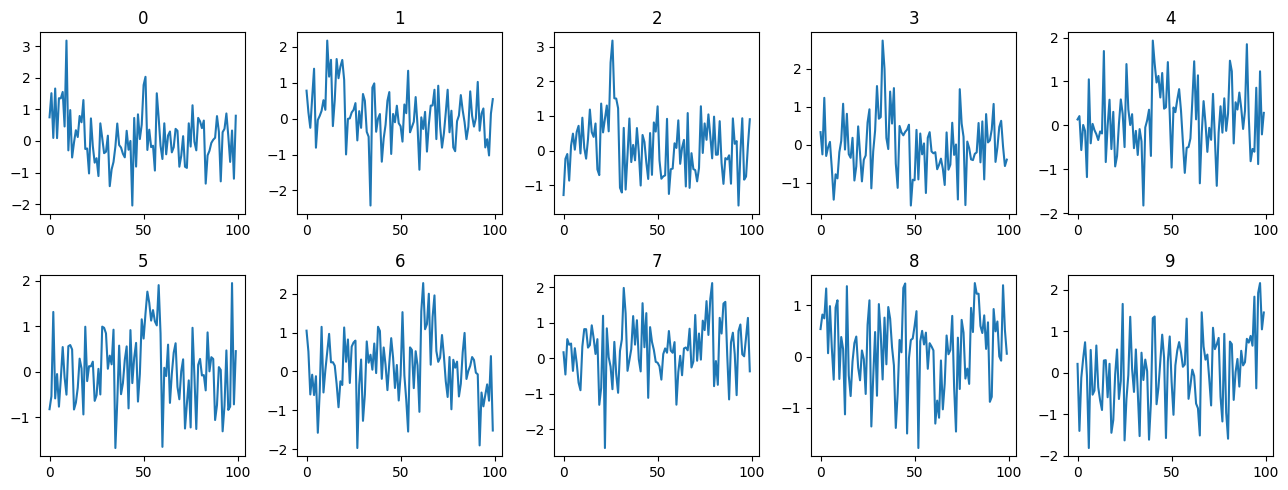

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
for label in range(10):
    plt.subplot(2, 5, label+1)
    vec = make_noise(torch.tensor([label])).cpu().ravel()
    plt.plot(vec)
    plt.title(label)
plt.tight_layout()

こう見るとわかり辛いが、移動平均をとるとしっかりと特徴が表れているのが分かる

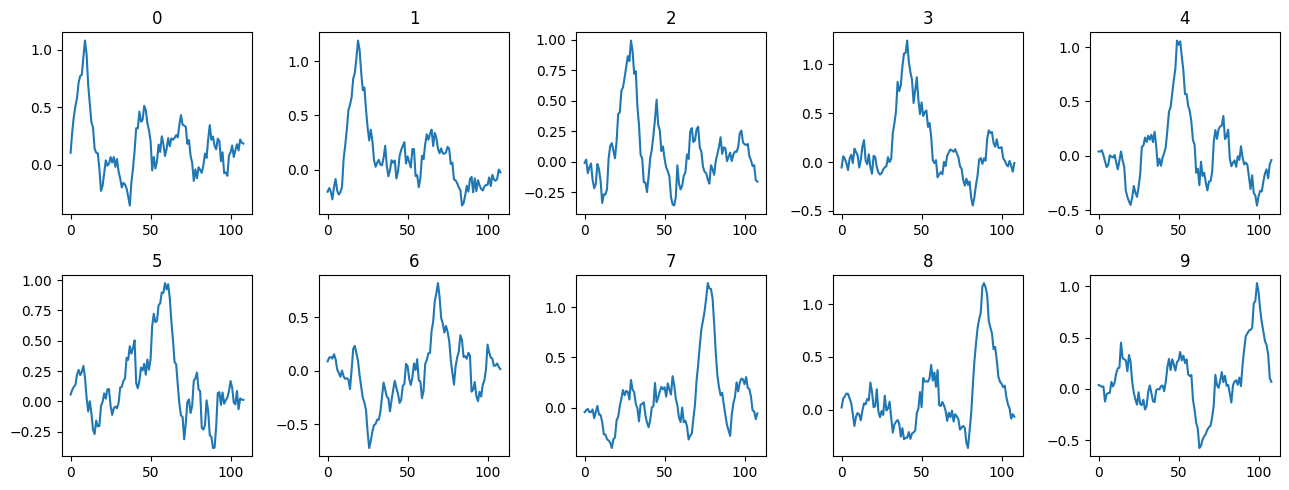

In [9]:
import numpy as np

plt.figure(figsize=(13, 5))
for label in range(10):
    plt.subplot(2, 5, label+1)
    vec = make_noise(torch.tensor([label])).cpu().numpy().ravel()
    vec = np.convolve(vec, np.ones(n_classes) / n_classes)
    plt.plot(vec)
    plt.title(label)
plt.tight_layout()

## 学習

In [11]:
# 画像描画
def write(netG, n_rows=1, size=64):
    n_images = n_rows * n_classes
    z = make_noise(torch.tensor(list(range(n_classes)) * n_rows))
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_images // n_rows)
    img = transforms.functional.to_pil_image(img)
    display(img)

# 間違ったラベルの生成
def make_false_labels(labels):
    diff = torch.randint(1, n_classes, size=labels.size(), device=device)
    fake_labels = (labels + diff) % n_classes
    return fake_labels

In [16]:
fake_labels = torch.zeros(batch_size, 1).to(device)
real_labels = torch.ones(batch_size, 1).to(device)
criterion = nn.BCELoss()

def train(netD, netG, optimD, optimG, n_epochs, write_interval=1):
    # 学習モード
    netD.train()
    netG.train()

    for epoch in range(1, n_epochs+1):
        for X, labels in dataloader:
            X = X.to(device) # 本物の画像
            labels = labels.to(device) # 正しいラベル
            false_labels = make_false_labels(labels) # 間違ったラベル

            # 勾配をリセット
            optimD.zero_grad()
            optimG.zero_grad()

            # Discriminatorの学習
            z = make_noise(labels) # ノイズを生成
            fake = netG(z) # 偽物を生成
            pred_fake = netD(fake, labels) # 偽物を判定
            pred_real_true = netD(X, labels) # 本物&正しいラベルを判定
            pred_real_false = netD(X, false_labels) # 本物&間違ったラベルを判定
            # 誤差を計算
            loss_fake = criterion(pred_fake, fake_labels)
            loss_real_true = criterion(pred_real_true, real_labels)
            loss_real_false = criterion(pred_real_false, fake_labels)
            lossD = loss_fake + loss_real_true + loss_real_false
            lossD.backward() # 逆伝播
            optimD.step() # パラメータ更新

            # Generatorの学習
            fake = netG(z) # 偽物を生成
            pred = netD(fake, labels) # 偽物を判定
            lossG = criterion(pred, real_labels) # 誤差を計算
            lossG.backward() # 逆伝播
            optimG.step() # パラメータ更新

        print(f'{epoch:>3}epoch | lossD: {lossD:.4f}, lossG: {lossG:.4f}')
        if write_interval and epoch % write_interval == 0:
            write(netG)

初期状態


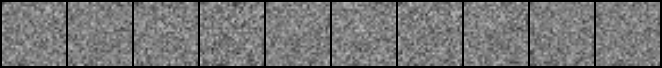

  1epoch | lossD: 0.3996, lossG: 4.7006


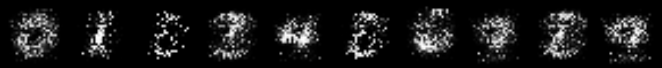

  2epoch | lossD: 0.4584, lossG: 4.0115


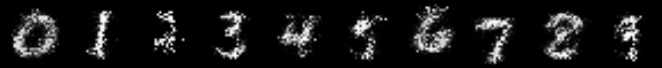

  3epoch | lossD: 0.3219, lossG: 3.8865


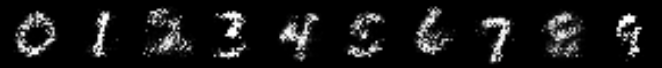

  4epoch | lossD: 0.2221, lossG: 3.5020


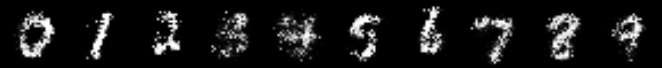

  5epoch | lossD: 0.3235, lossG: 4.4956


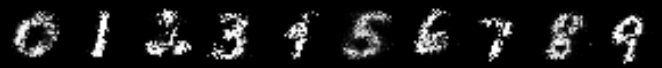

In [17]:
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 5

print('初期状態')
write(netG)
train(netD, netG, optimD, optimG, n_epochs)

数値ごとの特徴はとらえられている。ただちょっと形が崩れているので、もう少し学習させてみる。

  1epoch | lossD: 0.2528, lossG: 4.7041
  2epoch | lossD: 0.3173, lossG: 4.1171
  3epoch | lossD: 0.2703, lossG: 3.8704
  4epoch | lossD: 0.2824, lossG: 3.9017
  5epoch | lossD: 0.3200, lossG: 3.3116


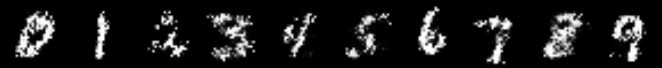

  6epoch | lossD: 0.1861, lossG: 4.7272
  7epoch | lossD: 0.1871, lossG: 3.9642
  8epoch | lossD: 0.3451, lossG: 4.4552
  9epoch | lossD: 0.1288, lossG: 5.6361
 10epoch | lossD: 0.1779, lossG: 6.4145


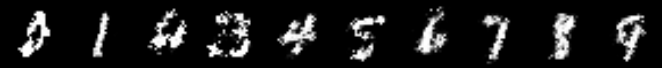

 11epoch | lossD: 0.3069, lossG: 5.3991
 12epoch | lossD: 0.2144, lossG: 4.8976
 13epoch | lossD: 0.2296, lossG: 6.6028
 14epoch | lossD: 0.3454, lossG: 5.5506
 15epoch | lossD: 0.2326, lossG: 4.1146


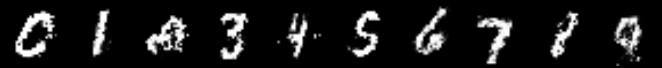

 16epoch | lossD: 0.1903, lossG: 4.5795
 17epoch | lossD: 0.3334, lossG: 7.3137
 18epoch | lossD: 0.1337, lossG: 4.9710
 19epoch | lossD: 0.2584, lossG: 4.4837
 20epoch | lossD: 0.3356, lossG: 5.4728


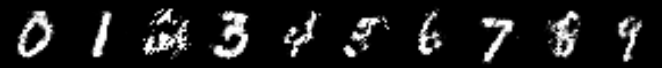

 21epoch | lossD: 0.4237, lossG: 4.9005
 22epoch | lossD: 0.4403, lossG: 4.9004
 23epoch | lossD: 0.2824, lossG: 4.6920
 24epoch | lossD: 0.2773, lossG: 4.5967
 25epoch | lossD: 0.3764, lossG: 5.1880


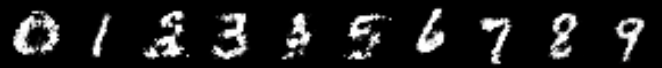

 26epoch | lossD: 0.4407, lossG: 4.2599
 27epoch | lossD: 0.3365, lossG: 4.1899
 28epoch | lossD: 0.4865, lossG: 3.1844
 29epoch | lossD: 0.3892, lossG: 3.7035
 30epoch | lossD: 0.4125, lossG: 4.1055


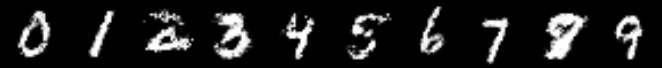

In [18]:
train(netD, netG, optimD, optimG, 30, 5)

学習が完了した。最終的に完成したGeneratorで10個ずつ画像を生成してみる。

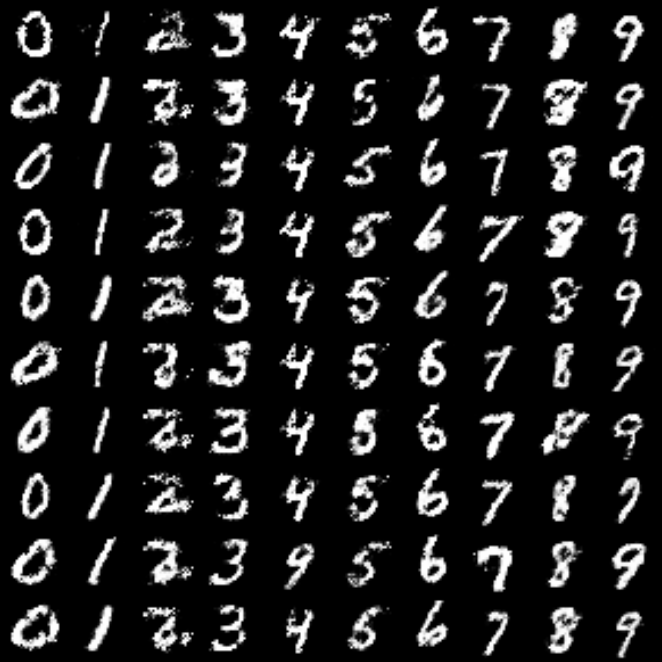

In [19]:
write(netG, 10)

まだ形が崩れているが、数字を認識できる程度にはなっている。

## CDCGAN

*Conditional Deep Convolitional GAN*

条件付きDCGAN。GeneratorとDiscriminatorにCNNを使うだけ。画像がきれいになることを期待する。

### Discriminator

畳み込みで得た特徴ベクトルに、ラベル（条件）のone-hotベクトルを結合して、全結合層に入力する。

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            self._conv_layer(1, 16, 4, 2, 1),
            self._conv_layer(16, 32, 4, 2, 1),
            self._conv_layer(32, 64, 3, 2, 0),
            nn.Conv2d(64, 128, 3, 1, 0),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(128 + n_classes, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self._eye = torch.eye(n_classes, device=device) # 条件ベクトル生成用の単位行列

    def _conv_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x, labels):
        x = self.conv(x) # 特徴抽出
        labels = self._eye[labels] # 条件(ラベル)をone-hotベクトルに
        x = torch.cat([x, labels], dim=1) # 画像と条件を結合
        y = self.fc(x)
        return y

### Generator

先ほど同様、条件の情報はノイズに持たせる。

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._convT(nz, 128, 3, 1, 0),
            self._convT(128, 64, 3, 2, 0),
            self._convT(64, 32, 4, 2, 1),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def _convT(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(-1, nz, 1, 1)
        y = self.net(x)
        return y

### 学習

まずは5epoch

初期状態


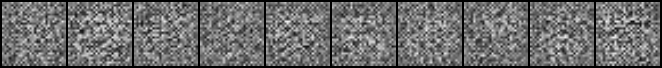

  1epoch | lossD: 1.3073, lossG: 6.6614


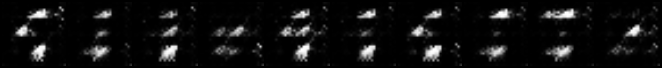

  2epoch | lossD: 1.1064, lossG: 4.6778


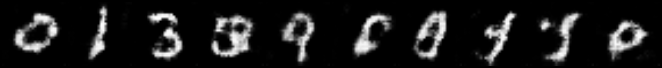

  3epoch | lossD: 0.8579, lossG: 4.6377


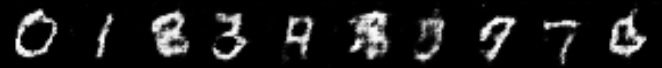

  4epoch | lossD: 0.6007, lossG: 4.1013


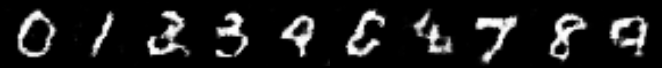

  5epoch | lossD: 0.9027, lossG: 2.7044


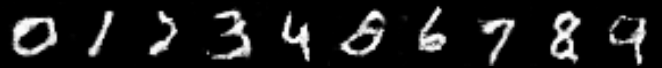

In [22]:
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 5

print('初期状態')
write(netG)
train(netD, netG, optimD, optimG, n_epochs)

線が綺麗になっている。追加でもう20epoch学習させてみる。

  1epoch | lossD: 0.8197, lossG: 2.0744
  2epoch | lossD: 0.5615, lossG: 2.4900
  3epoch | lossD: 0.6032, lossG: 2.8734
  4epoch | lossD: 0.8999, lossG: 1.8643
  5epoch | lossD: 1.0089, lossG: 1.8831


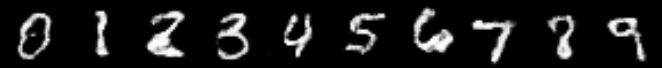

  6epoch | lossD: 0.7875, lossG: 1.7236
  7epoch | lossD: 1.1012, lossG: 1.6621
  8epoch | lossD: 0.7958, lossG: 1.8463
  9epoch | lossD: 1.1437, lossG: 1.5790
 10epoch | lossD: 0.9427, lossG: 2.1609


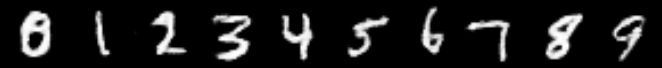

 11epoch | lossD: 1.3711, lossG: 1.5304
 12epoch | lossD: 0.8763, lossG: 1.4354
 13epoch | lossD: 0.8779, lossG: 1.7089
 14epoch | lossD: 1.0158, lossG: 1.3854
 15epoch | lossD: 0.8978, lossG: 1.3863


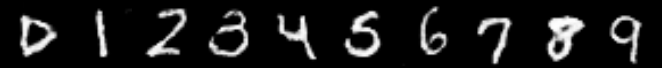

 16epoch | lossD: 0.9916, lossG: 1.8766
 17epoch | lossD: 0.9548, lossG: 1.8286
 18epoch | lossD: 0.9505, lossG: 1.4026
 19epoch | lossD: 1.2317, lossG: 1.7795
 20epoch | lossD: 0.7817, lossG: 1.7728


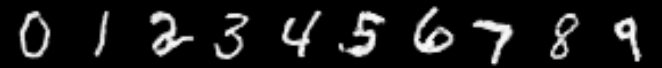

In [23]:
train(netD, netG, optimD, optimG, 20, 5)

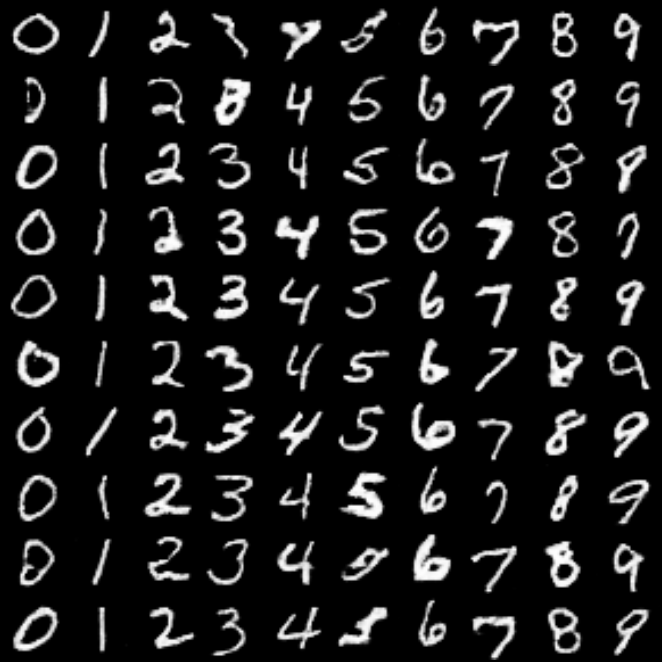

In [25]:
write(netG, 10)

線は綺麗だが、少し形が乱れることがあるよう。